In [15]:
import tensorflow as tf
import PIL
import numpy as np
import IPython.display as display

In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 4s 0us/step


In [3]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [4]:
output_layers = ['mixed3', 'mixed5']
outputs = [base_model.get_layer(layer).output for layer in output_layers]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [8]:
dream_model.output_shape

[(None, None, None, 768), (None, None, None, 768)]

In [10]:
def load_image(path, max_dim=None):
  image = PIL.Image.open(path)
  if max_dim:
    image.thumbnail((max_dim, max_dim))
  return np.array(image)

In [30]:
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

In [13]:
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

In [12]:
img_path = 'drive/MyDrive/TIES4911/task5/img-2.jpg'
original_img = load_image(img_path, max_dim=500)

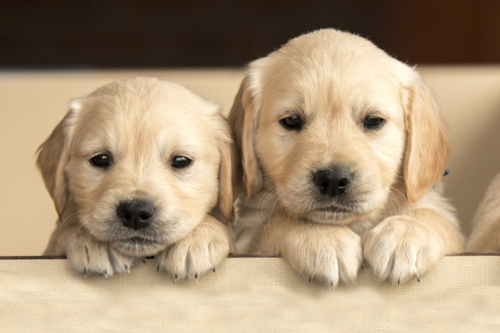

In [16]:
show(original_img)

In [25]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

In [27]:
img = tf.keras.applications.inception_v3.preprocess_input(original_img)
print(calc_loss(img, dream_model))

tf.Tensor(0.6554785, shape=(), dtype=float32)


In [34]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function
  def __call__(self, img, steps, step_size):
    loss = tf.constant(0.0)
    for n in range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, self.model)
      
      grad = tape.gradient(loss, img)
      grad /= tf.math.reduce_std(grad) + 1e-8

      img = img + grad*step_size
      img = tf.clip_by_value(img, -1, 1)
    
    return loss, img

In [36]:
deepdream = DeepDream(dream_model)

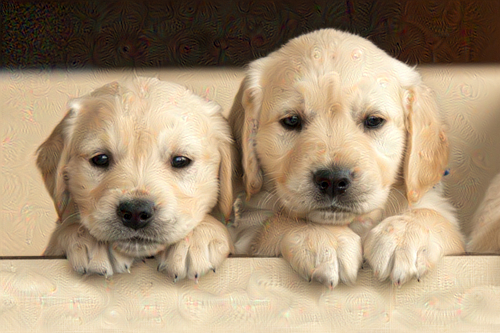

Step 10, loss 1.2124956846237183


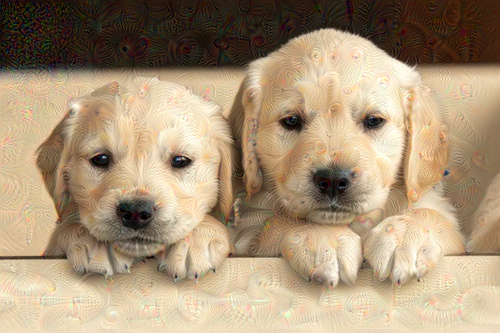

Step 20, loss 1.4762990474700928


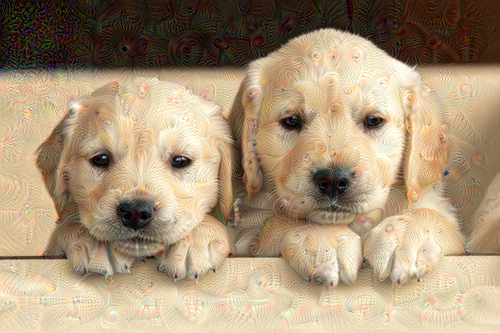

Step 30, loss 1.6477985382080078


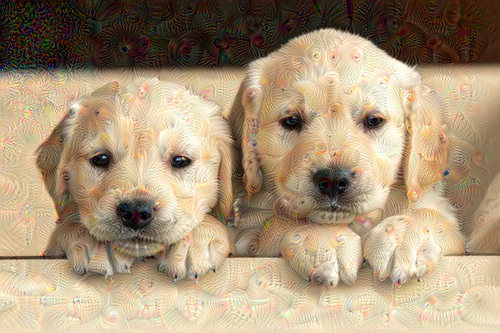

Step 40, loss 1.774479866027832


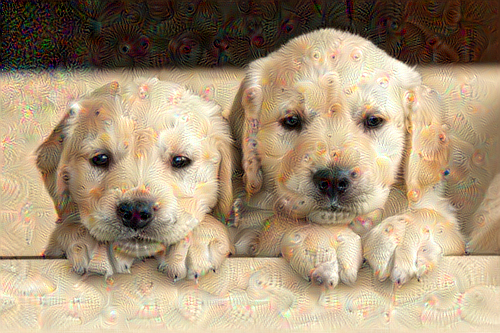

Step 50, loss 1.8707151412963867


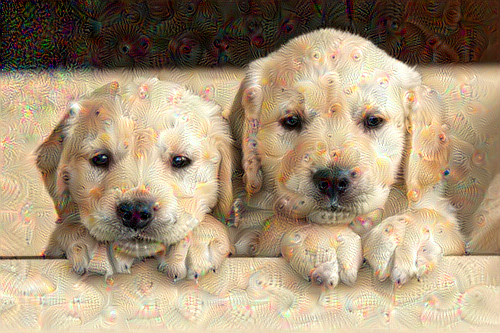

Step 60, loss 1.9540308713912964


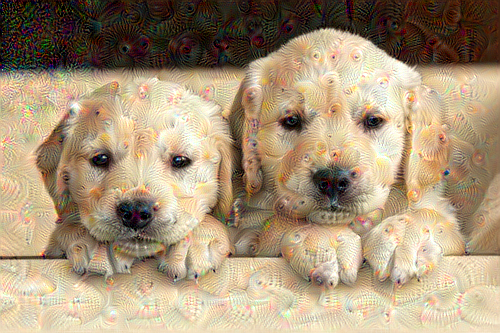

Step 70, loss 2.0265913009643555


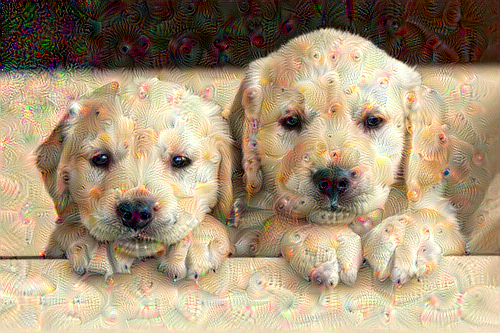

Step 80, loss 2.0869946479797363


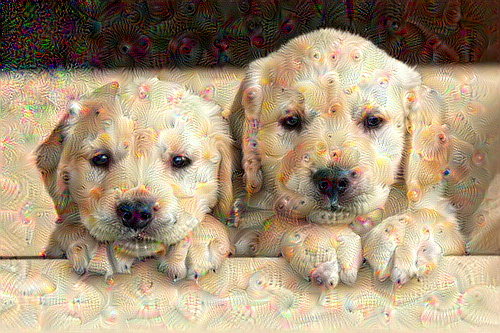

Step 90, loss 2.1417040824890137


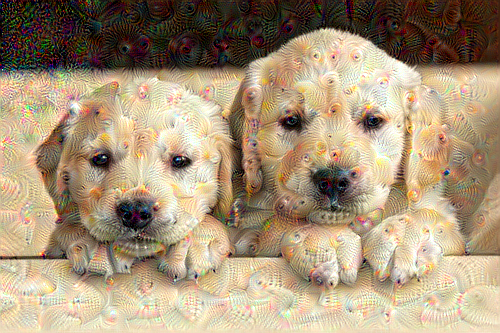

Step 100, loss 2.194615364074707


In [37]:
step_size = 0.01
steps = 10

img = tf.keras.applications.inception_v3.preprocess_input(original_img)
img = tf.convert_to_tensor(img)
step_size = tf.convert_to_tensor(step_size)
step_remaining = 100
step = 0
while step_remaining:
  if step_remaining > 10:
    run_steps = 10
  else:
    run_steps = tf.constant(step_remaining)
  
  step_remaining -= run_steps
  step += run_steps

  loss, img = deepdream(img, steps, step_size)
  show(deprocess(img))
  print('Step {}, loss {}'.format(step, loss))